# Autograd

Autograd is the automatic differentiation library that is used by PyTorch. We do not need to import the library explicitly, because autograd is integrated into PyTorch.

In [1]:
import torch

Let's assume that we are dealing with the function $f(x,y) = 2x^2 + y^2$ and that our initial values are $x = 10$ and $y=-7$. Our goal is to find the $x$ and $y$ values that minimize the function. We can draw the function to eyeball where the coordinates of the minimum value lie.

In [2]:
import matplotlib.pyplot as plt
import numpy as np

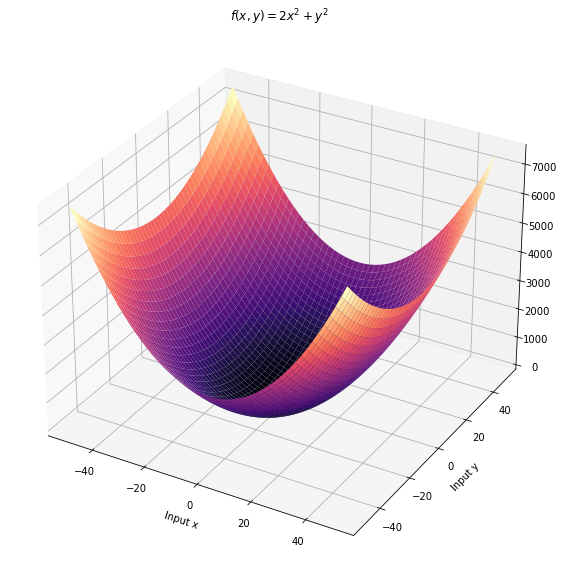

In [3]:
plt.figure(figsize=(10, 10))
ax = plt.axes(projection="3d")
X, Y = np.meshgrid(np.arange(-50, 50, 0.1), np.arange(-50, 50, 0.1))
Z = 2 * X**2 + Y**2
ax.plot_surface(X, Y, Z, cmap="magma")

plt.title("$f(x, y) = 2x^2 + y^2$")
plt.xlabel("Input x")
plt.ylabel("Input y")

plt.show()

If we want to find the value through gradient descent we need to follow some steps.

First we generate two torch variables (x and y) and we set the parameter ```requires_grad``` to ```True```. That way PyTorch knows that it will need to calculate the gradients for those variables. Variables that have ```requires_grad```set to ```False``` are treated as constants in the computation of the gradients.

In [4]:
x = torch.tensor(10.0, dtype=torch.float32, requires_grad=True)
y = torch.tensor(-7.0, dtype=torch.float32, requires_grad=True)
print(f'X: {x}. Y: {y}')

X: 10.0. Y: -7.0


Next we calculate the output value for $f(x, y) = 2x^2 + y^2$, given that $x=10$ and $y=-7$. This is basically the forward step. In this step PyTorch remembers which variables contribute to the calculation of the function that we want to differentiate.

In [5]:
f = 2*x**2 + y**2

In the next step we call ```f.backward()```. This function calculates the gradients for all tracked variables (requires_grad=True) that were used to calculate the function. The `backward()` method is basically the backpropagation algorithm.

In [6]:
f.backward()

Those gradients can be accessed by simply using ```variable_name.grad```.

In [7]:
print(x.grad)
print(y.grad)

tensor(40.)
tensor(-14.)


If we apply the basic rules of calculus, we find that those numbers make sence because $\dfrac{\partial}{\partial x} f(x,y) = 4x$ and $\dfrac{\partial}{\partial y} f(x,y) = 2y$

Now we can use gradient descent.

$x := x - \alpha \dfrac{\partial}{\partial x} f(x,y)$

$y := y - \alpha \dfrac{\partial}{\partial y} f(x,y)$

There is still one difficulty ahead, if we simply write ```x -= alpha * x.grad``` PyTorch will track this calculation, because `x` has `requires_grad` set to true. We need a method to deactivate the calculation of gradients temporarily. We could obviously swith the calculation by using ```x.requres_grad = False```, but we would need to reverse this step the next time we would like to calculate the gradients for that variable. PyTorch provides methods that deactivate the tracking of variables temporarily. ```Tensor.detach()``` for example detaches the variable from the computation graph and returns a variable with the same value, but one that is not tracked by autograd.

In [8]:
# computation not tracked for new_var
new_var = x.detach()
print(x.requires_grad)
print(new_var.requires_grad)

True
False


Instead of the ```detach()``` method we are going to utilze context managers. All executions that are done within the ```torch.no_grad()``` context are excluded from the calculation of the gradient. Since the version 1.9 PyTorch has a new context ```torch.inference_mode()```. ```torch.inference_mode()``` is preferable to ```torch.no_grad()```, because the mode is more optimized for performance. 

In [9]:
alpha = 0.1
with torch.inference_mode():
    x.sub_(alpha * x.grad)
    y.sub_(alpha * y.grad)

In [10]:
print(f'X: {x}, Y: {y}')

X: 6.0, Y: -5.599999904632568


Next we have to clear the gradients. PyTorch accumulates gradients each time we run the ```backward()``` command. If we didn't clear the gradients the ```grad``` variable would contain the sum of all the gradients we have calculated so far and we are only interested in the last gradient.

Below we calculate $f(x,y)$ and determine the gradients several times in a row. Each time the magnitude of gradients grows. This behaviour might lead to unexpected results.

In [11]:
for i in range(5):
    f = 2*x**2 + y**2
    f.backward()
    print(f'x grad: {x.grad}, y grad: {y.grad}')

x grad: 64.0, y grad: -25.200000762939453
x grad: 88.0, y grad: -36.400001525878906
x grad: 112.0, y grad: -47.60000228881836
x grad: 136.0, y grad: -58.80000305175781
x grad: 160.0, y grad: -70.0


We can use the `zero_()` function that zeroes the gradients inplace.

In [12]:
for i in range(5):
    f = 2*x**2 + y**2
    f.backward()
    x.grad.zero_()
    y.grad.zero_()
    print(f'x grad: {x.grad}, y grad: {y.grad}')

x grad: 0.0, y grad: 0.0
x grad: 0.0, y grad: 0.0
x grad: 0.0, y grad: 0.0
x grad: 0.0, y grad: 0.0
x grad: 0.0, y grad: 0.0


Finally we can run the gradient descent algorithm for several episodes to see if we can come close to the optimium.

In [13]:
for i in range(50):
    
    # empty the gradients
    x.grad.zero_()
    y.grad.zero_()
    
    # calculate f(x, y) - forward step
    f = 2*x**2 + y**2
    
    #calculate the gradients - backward step
    f.backward()
    
    #apply gradient descent
    alpha = 0.1
    with torch.no_grad():
        x.sub_(alpha * x.grad)
        y.sub_(alpha * y.grad)
   
print(f'X: {x}, Y: {y}, f(x, y): {f}')

X: 4.849684889784989e-11, Y: -7.992585597094148e-05, f(x, y): 9.981471649211926e-09


After 50 iterations we come very close the minimum variable values $x=0$ and $y=0$.